# Import libraries

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

from sklearn.model_selection import train_test_split

import cv2

from tqdm import tqdm_notebook #, tnrange

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

In [2]:
print(tf.__version__)

1.10.1


# Clean data 

In [3]:
DATA_DIR = 'data/salt/'

In [4]:
version = 4
basic_name = f'unet_v1_{version}'
save_model_name = basic_name + 'A.model'
save_model_nameB = basic_name + 'B.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(save_model_nameB)
print(submission_file)

unet_v1_4A.model
unet_v1_4B.model
unet_v1_4.csv


In [5]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True, anti_aliasing=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True, anti_aliasing=True)

# Stratify data by depth

In [6]:
# Loading of training/testing ids and depths
train_df = pd.read_csv(f"{DATA_DIR}train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(f"{DATA_DIR}depths.csv", index_col="id")
train_df = train_df.join(depths_df)

test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [7]:
img_list = []
mask_list = []

for idx in tqdm_notebook(train_df.index):
    img = load_img(f"{DATA_DIR}train/images/{idx}.png", grayscale=True)
    mask = load_img(f"{DATA_DIR}train/masks/{idx}.png", grayscale=True)
    
    img_list.append(np.array(img)/255)
    mask_list.append(np.array(mask)/255)
    
train_df['images'] = img_list
train_df['masks'] = mask_list

In [8]:
low_pix_list = train_df.masks[(train_df.masks.map(np.sum)<=10) & (train_df.masks.map(np.sum)>0)].index
train_df = train_df.drop(low_pix_list, axis=0)

In [9]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df["coverage_class"] = train_df.coverage.apply(lambda val: np.int(np.ceil(val*10)))

Text(0.5, 0, 'Coverage class')

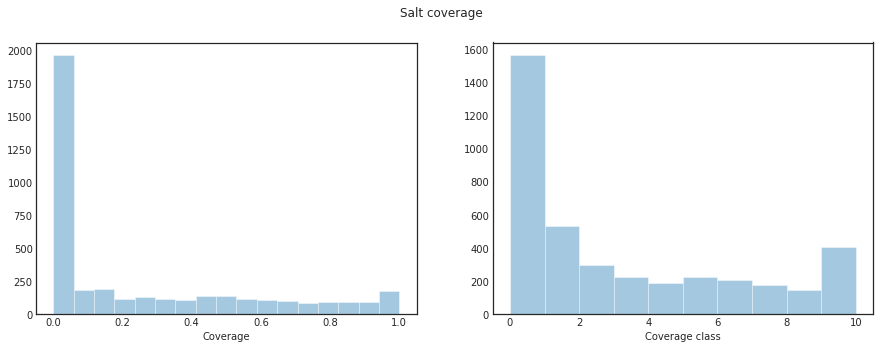

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5, 0, 'Coverage class')

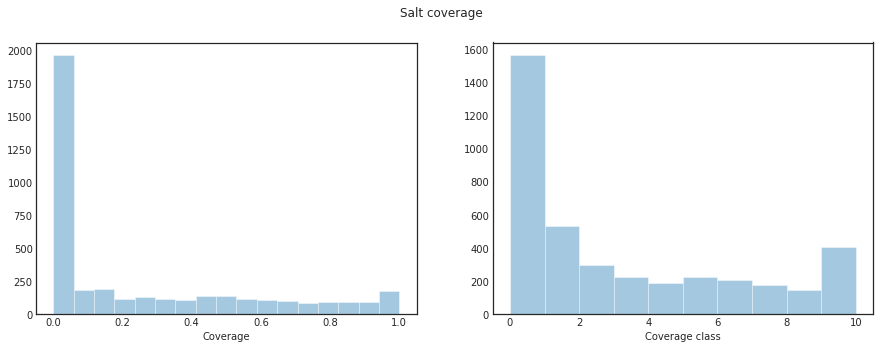

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5, 1.0, 'Depth distribution')

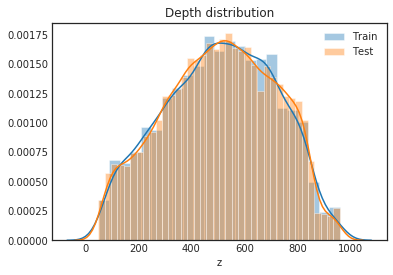

In [12]:
# Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

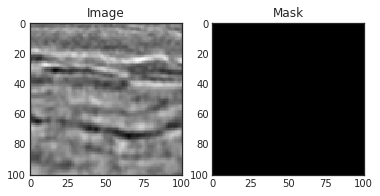

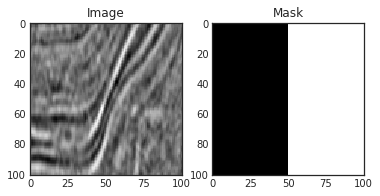

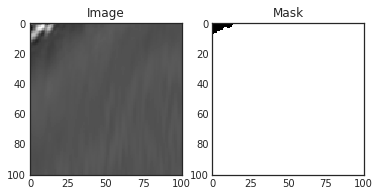

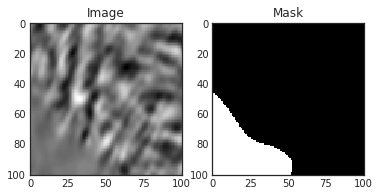

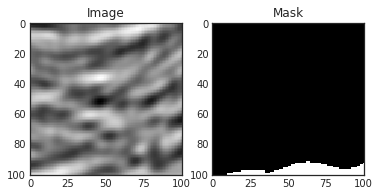

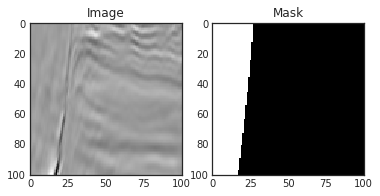

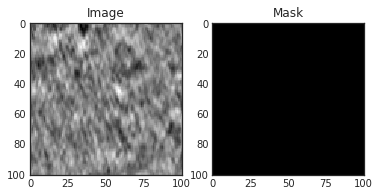

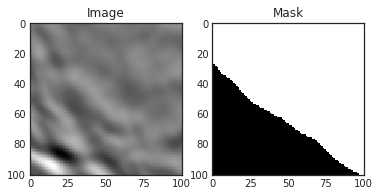

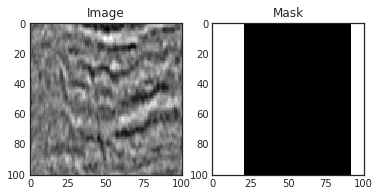

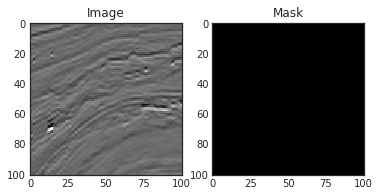

In [13]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image, cmap="gray")
    axarr[1].imshow(mask, cmap="gray")
    axarr[0].grid(False)
    axarr[1].grid(False)
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')
    
for i, idx in enumerate(train_df.index[:10]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    plot2x2Array(img, mask)

Text(0.5, 0.98, 'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

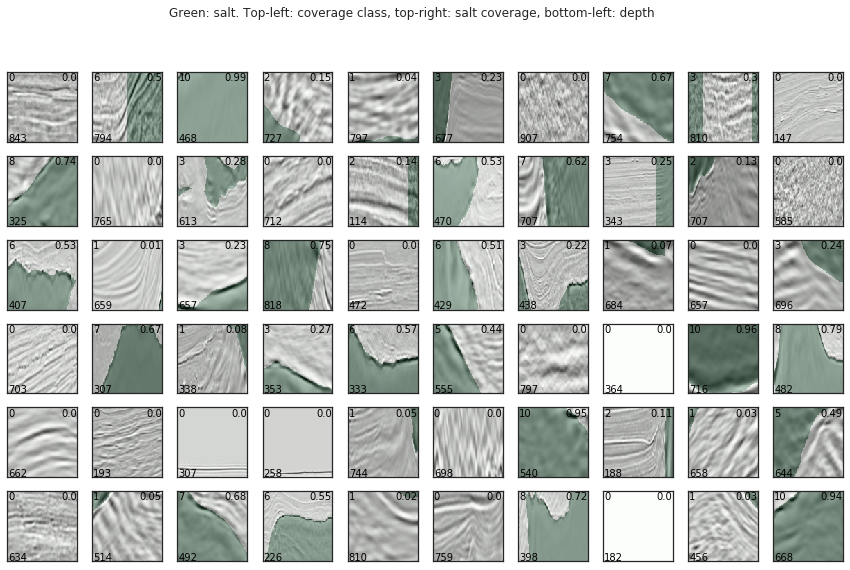

In [14]:
max_images = 60
grid_width = 10
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*1.5, grid_height*1.5))

for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Split data

stratified by salt coverage

In [15]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, 
    stratify=train_df.coverage_class, 
    random_state=1234)

# Augment Data

In [16]:
print(x_train.shape)
print(y_valid.shape)

(3164, 101, 101, 1)
(791, 101, 101, 1)


In [17]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [18]:
print(x_train.shape)
print(y_valid.shape)

(6328, 101, 101, 1)
(791, 101, 101, 1)


To be improved with Albumentations
https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb

# Create Metrics

In [19]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0], tf.float64)

In [20]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        #loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

# Define blocks and model

In [21]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [22]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

# Build model and set hyperparameters

In [23]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, 0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.Adam(lr=0.001)

model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

In [24]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode='max', patience=21, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name, monitor='val_my_iou_metric', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

epochs = 300
batch_size = 32

# Train

In [25]:
%%time
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

Train on 6328 samples, validate on 791 samples
Epoch 1/300
6328/6328 [==============================] - 103s 16ms/step - loss: 0.3839 - my_iou_metric: 0.3503 - val_loss: 7.1009 - val_my_iou_metric: 0.1348

Epoch 00001: val_my_iou_metric improved from -inf to 0.13477, saving model to unet_v1_4A.model
Epoch 2/300
6328/6328 [==============================] - 89s 14ms/step - loss: 0.2790 - my_iou_metric: 0.5396 - val_loss: 2.0814 - val_my_iou_metric: 0.2668

Epoch 00002: val_my_iou_metric improved from 0.13477 to 0.26675, saving model to unet_v1_4A.model
Epoch 3/300
6328/6328 [==============================] - 89s 14ms/step - loss: 0.2460 - my_iou_metric: 0.5905 - val_loss: 0.4306 - val_my_iou_metric: 0.3770

Epoch 00003: val_my_iou_metric improved from 0.26675 to 0.37699, saving model to unet_v1_4A.model
Epoch 4/300
6328/6328 [==============================] - 89s 14ms/step - loss: 0.2314 - my_iou_metric: 0.5896 - val_loss: 0.2432 - val_my_iou_metric: 0.6135

Epoch 00004: val_my_iou_metri


Epoch 00035: val_my_iou_metric did not improve from 0.77863
Epoch 36/300
6328/6328 [==============================] - 88s 14ms/step - loss: 0.0931 - my_iou_metric: 0.7788 - val_loss: 0.1284 - val_my_iou_metric: 0.7791

Epoch 00036: val_my_iou_metric improved from 0.77863 to 0.77914, saving model to unet_v1_4A.model
Epoch 37/300
6328/6328 [==============================] - 88s 14ms/step - loss: 0.0963 - my_iou_metric: 0.7747 - val_loss: 0.1177 - val_my_iou_metric: 0.7853

Epoch 00037: val_my_iou_metric improved from 0.77914 to 0.78534, saving model to unet_v1_4A.model
Epoch 38/300
6328/6328 [==============================] - 89s 14ms/step - loss: 0.0915 - my_iou_metric: 0.7805 - val_loss: 0.1472 - val_my_iou_metric: 0.7800

Epoch 00038: val_my_iou_metric did not improve from 0.78534
Epoch 39/300
6328/6328 [==============================] - 89s 14ms/step - loss: 0.0907 - my_iou_metric: 0.7783 - val_loss: 0.1274 - val_my_iou_metric: 0.7695

Epoch 00039: val_my_iou_metric did not improve 

# Remove later activation layer and use losvasz loss

In [23]:
# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model1 = load_model(save_model_name, custom_objects={'my_iou_metric': my_iou_metric})

input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.Adam(lr = 0.0005)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

# Set hyperparameters

In [23]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

c = optimizers.Adam(lr = 0.0005)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

In [24]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=21, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameB, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max',factor=0.5, patience=7, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

# Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                    verbose=1)

Train on 6328 samples, validate on 791 samples
Epoch 1/200
6328/6328 [==============================] - 206s 33ms/step - loss: -0.1971 - my_iou_metric_2: 0.8197 - val_loss: -0.0016 - val_my_iou_metric_2: 0.7871

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.78710, saving model to unet_v1_4B.model
Epoch 2/200
6328/6328 [==============================] - 192s 30ms/step - loss: -0.2346 - my_iou_metric_2: 0.8225 - val_loss: -0.0433 - val_my_iou_metric_2: 0.7881

Epoch 00002: val_my_iou_metric_2 improved from 0.78710 to 0.78812, saving model to unet_v1_4B.model
Epoch 3/200
6328/6328 [==============================] - 191s 30ms/step - loss: -0.2644 - my_iou_metric_2: 0.8269 - val_loss: -0.0828 - val_my_iou_metric_2: 0.7967

Epoch 00003: val_my_iou_metric_2 improved from 0.78812 to 0.79671, saving model to unet_v1_4B.model
Epoch 4/200
6328/6328 [==============================] - 191s 30ms/step - loss: -0.2699 - my_iou_metric_2: 0.8277 - val_loss: -0.1202 - val_my_iou_metric_2: 0.79

In [25]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                    verbose=1)

Train on 6328 samples, validate on 791 samples
Epoch 1/200
6328/6328 [==============================] - 205s 32ms/step - loss: -0.3432 - my_iou_metric_2: 0.8399 - val_loss: -0.1792 - val_my_iou_metric_2: 0.8107

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.81075, saving model to unet_v1_4B.model
Epoch 2/200
6328/6328 [==============================] - 190s 30ms/step - loss: -0.3736 - my_iou_metric_2: 0.8443 - val_loss: -0.1674 - val_my_iou_metric_2: 0.8163

Epoch 00002: val_my_iou_metric_2 improved from 0.81075 to 0.81631, saving model to unet_v1_4B.model
Epoch 3/200
6328/6328 [==============================] - 190s 30ms/step - loss: -0.3619 - my_iou_metric_2: 0.8387 - val_loss: -0.1542 - val_my_iou_metric_2: 0.8147

Epoch 00003: val_my_iou_metric_2 did not improve from 0.81631
Epoch 4/200
6328/6328 [==============================] - 190s 30ms/step - loss: -0.3783 - my_iou_metric_2: 0.8433 - val_loss: -0.1180 - val_my_iou_metric_2: 0.8128

Epoch 00004: val_my_iou_metric_2 d


Epoch 00034: val_my_iou_metric_2 did not improve from 0.82579
Epoch 35/200
6328/6328 [==============================] - 190s 30ms/step - loss: -0.5628 - my_iou_metric_2: 0.8776 - val_loss: -0.1540 - val_my_iou_metric_2: 0.8206

Epoch 00035: val_my_iou_metric_2 did not improve from 0.82579
Epoch 36/200
6328/6328 [==============================] - 190s 30ms/step - loss: -0.5685 - my_iou_metric_2: 0.8797 - val_loss: -0.1618 - val_my_iou_metric_2: 0.8216

Epoch 00036: val_my_iou_metric_2 did not improve from 0.82579
Epoch 37/200
6328/6328 [==============================] - 190s 30ms/step - loss: -0.5708 - my_iou_metric_2: 0.8791 - val_loss: -0.1600 - val_my_iou_metric_2: 0.8262

Epoch 00037: val_my_iou_metric_2 improved from 0.82579 to 0.82617, saving model to unet_v1_4B.model
Epoch 38/200
6328/6328 [==============================] - 190s 30ms/step - loss: -0.5721 - my_iou_metric_2: 0.8803 - val_loss: -0.1479 - val_my_iou_metric_2: 0.8241

Epoch 00038: val_my_iou_metric_2 did not improve 

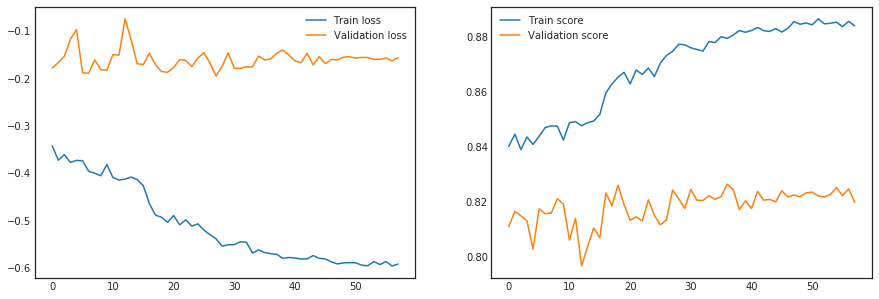

In [26]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()

ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")

ax_score.legend()

# Train one more round

In [23]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

c = optimizers.Adam(lr = 0.0001)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

In [24]:
save_model_nameC = basic_name + 'C.model'
save_model_nameC

'unet_v1_4C.model'

In [25]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameC, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max',factor=0.5, patience=6, min_lr=0.00001, verbose=1)

epochs = 100
batch_size = 32

In [26]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                    verbose=1)

Train on 6328 samples, validate on 791 samples
Epoch 1/100
6328/6328 [==============================] - 207s 33ms/step - loss: -0.5683 - my_iou_metric_2: 0.8790 - val_loss: -0.1425 - val_my_iou_metric_2: 0.8178

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.81783, saving model to unet_v1_4C.model
Epoch 2/100
6328/6328 [==============================] - 191s 30ms/step - loss: -0.5730 - my_iou_metric_2: 0.8799 - val_loss: -0.1624 - val_my_iou_metric_2: 0.8172

Epoch 00002: val_my_iou_metric_2 did not improve from 0.81783
Epoch 3/100
6328/6328 [==============================] - 191s 30ms/step - loss: -0.5655 - my_iou_metric_2: 0.8786 - val_loss: -0.1592 - val_my_iou_metric_2: 0.8176

Epoch 00003: val_my_iou_metric_2 did not improve from 0.81783
Epoch 4/100
  64/6328 [..............................] - ETA: 2:53 - loss: -0.7576 - my_iou_metric_2: 0.9422

KeyboardInterrupt: 

# Plot Result

NameError: name 'history' is not defined

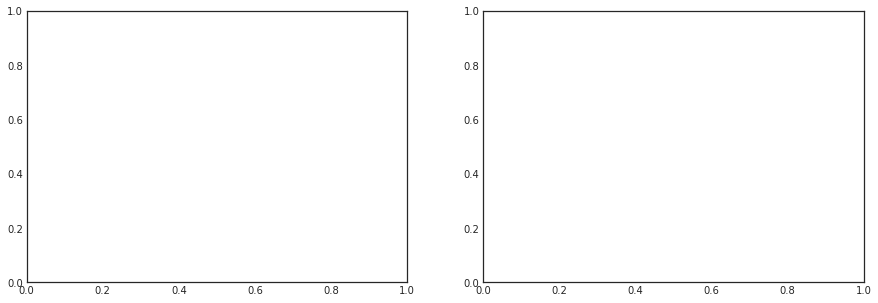

In [27]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()

ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")

ax_score.legend()

# Predict on Test Data

In [28]:
model = load_model(save_model_nameB, custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [ ]:
model = load_model(save_model_nameC, custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [29]:
def predict_result(model, x_test, img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [30]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [31]:
# Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
      
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [32]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.82515803 0.82629583 0.82819216 0.82768647 0.82958281 0.82958281
 0.82907712 0.83072061 0.83059418 0.82970923 0.8300885  0.8312263
 0.8312263  0.83261694 0.83261694 0.83261694 0.83286979 0.83324905
 0.83312263 0.83438685 0.83388116 0.8335019  0.83438685 0.83413401
 0.83426043 0.83413401 0.83413401 0.83451327 0.83362832 0.83400759
 0.83337547]


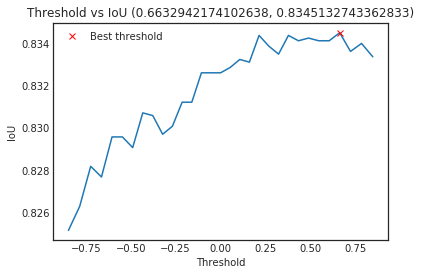

In [33]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [34]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [35]:
test_img_list = []

for idx in tqdm_notebook(test_df.index):
    test_img = load_img(f"{DATA_DIR}test/images/{idx}.png", grayscale=True)
    test_img_list.append((np.array(test_img)/255))
    
x_test = np.array(test_img_list).reshape(-1, img_size_target, img_size_target, 1)

In [36]:
x_test.shape

(18000, 101, 101, 1)

In [37]:
%%time
preds_test = predict_result(model, x_test, img_size_target)

CPU times: user 1min 24s, sys: 34.3 s, total: 1min 59s
Wall time: 1min 47s


In [39]:
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 6.425737142562866 s


In [40]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [41]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 0.26775496939818066 hours
